In [1]:
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import importlib
import FVMF
importlib.reload(FVMF)
import test_ensemble
importlib.reload(test_ensemble)
import matplotlib.pyplot as plt

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
COND_OPT = False
CLASSES = 10
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50


DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)


#d_CIFAR_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
#d_CIFAR_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

#print(transforms.ToTensor(cifar_train))
#print(dtrain[0].shape)

#Ok so this is actually not trivial... Maybe we need to place a convulutional layer first in order to properly parse this into
#our vMF so that we don't lose the positionality of our data?

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=6000, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=10000, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

for batch_idx, (data, target) in enumerate(train_loader):
    train_data, train_target = data.to(DEVICE), target.to(DEVICE)
#print(train_data.shape)

for batch_idx, (data, target) in enumerate(test_loader):
    test_data, test_target = data.to(DEVICE), target.to(DEVICE)
#test_data = torch.cat

#dtrain Må pakke den inn i en dimensjon... kanskje?

In [3]:
print(train_data.shape,test_data.shape)
print(train_target.shape,test_target.shape)

dtrain = torch.flatten(train_data, start_dim=1, end_dim= -1)
#print(dtrain.shape)

dtest = torch.flatten(test_data, start_dim=1, end_dim= -1)
#print(dtest.shape)

#print(train_target.shape)
#dtrain = torch.cat((dtrain,train_target), dim = 0)

train_target1 = torch.reshape(train_target,(6000, 1))
#print(train_target1.shape)

dtrain = torch.cat((dtrain,train_target1), dim = 1).numpy(force=True)
print(dtrain.shape)

test_target1 = torch.reshape(test_target,(10000, 1))
#print(test_target1.shape)

dtest = torch.cat((dtest,test_target1), dim = 1).numpy(force=True)
print(dtest.shape)

torch.Size([6000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
torch.Size([6000]) torch.Size([10000])
(6000, 785)
(10000, 785)


In [4]:
l1shape=(784,10)
l2shape=(10, 10)
l3shape=(10, 10)
#l4shape=(10, 10)
#layershapes = [l1shape, l2shape, l3shape, l4shape]
layershapes = [l1shape, l2shape, l3shape]
data_shape = (0,784,784,785)

0
Random Init Utilized
oui


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(104.2318, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(90.4211, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(69.1057, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(55.5301, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(61.5567, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(48.2766, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(53.1863, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.1097, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(53.8075, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.1770, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(47.4768, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(34.6172, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(50.1192, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: ten

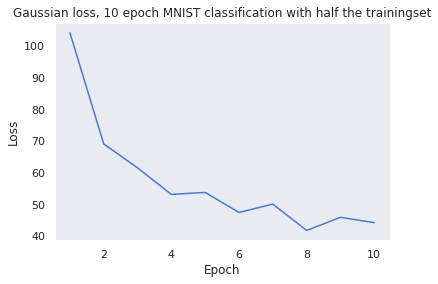

In [5]:
epochs = 10
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification',VISION = 'dense').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.007)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")


x = []
for i in range(epochs):
    x.append(i+1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 10 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_10_epoch_MNIST_VISION.png')
plt.show()

1
loss: tensor(33.8879, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(33.8879, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(29.5132, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(29.5132, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(27.3405, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(27.3405, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(24.2987, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(24.2987, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(27.6094, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(27.6094, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(18.6442, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(18.6442, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(17.4423, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tens

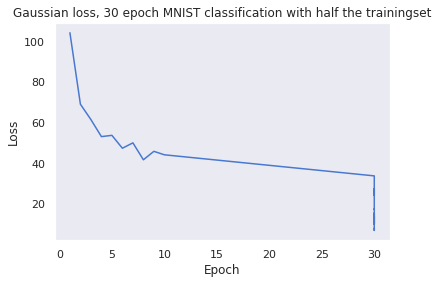

In [6]:
epochs = 20
for epoch in range(epochs):

    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
    trtimes.append(train[1].detach().cpu().numpy())
    #print(net.l1.weight_mu.mean())


for i in range(epochs):
    x.append(10+epochs)
res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 30 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_30_epoch_MNIST_VISION.png')
plt.show()

In [7]:
epochs = 20
for epoch in range(epochs):

    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
    trtimes.append(train[1].detach().cpu().numpy())
    #print(net.l1.weight_mu.mean())

res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)



1
loss: tensor(13.3114, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.3114, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(7.7508, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(7.7508, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(10.6834, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(10.6834, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(7.1024, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(7.1024, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(2.0641, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(2.0641, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(6.3739, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(6.3739, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(4.8710, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(4.8710

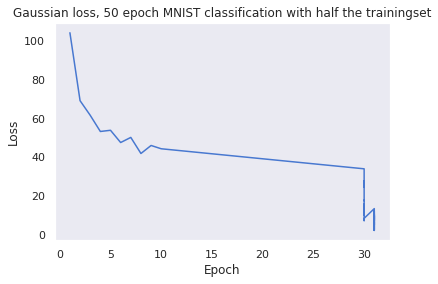

In [8]:
for i in range(epochs):
    x.append(30+1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 50 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_50_epoch_MNIST_VISION.png')
plt.show()

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
oui
1
loss: tensor(155.6080, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(150.2879, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(1.8877, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(10.6919, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(145.5968, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(140.3678, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.4283, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(10.4877, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(115.7345, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(110.8213, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.8805, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.0285, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(117.0237, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(111.8511, de

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

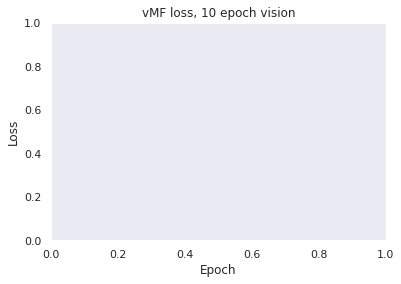

In [13]:
importlib.reload(FVMF)
epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification',VISION = 'dense')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 10 epoch vision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x[:10],trtimes)
plt.savefig('Plots/vMF_loss_10_epoch_vision.png')
plt.show()

In [ ]:
g = [1,2,3,4,5]
print(g[1:])

In [ ]:
r"""
Just use a Gaussian first layer for the vMF?
"""